In [16]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.metrics import f1_score
from tqdm import tqdm

In [17]:
# 데이터 로드
######################
train_df = pd.read_csv("/content/sample_data/aug_train_data.csv")
test_df = pd.read_csv("/content/sample_data/test.csv")

labels = train_df["class"].unique().tolist()
label_encoder = LabelEncoder()
train_df["label"] = label_encoder.fit_transform(train_df["class"])

X = train_df["text"].values
y = train_df["label"].values

X_train, X_val, y_train, y_val = train_test_split(X, y,
                                                  test_size=0.2,
                                                  random_state=42,
                                                  stratify=y)
train_df_split = pd.DataFrame({"text": X_train, "label": y_train})
val_df_split = pd.DataFrame({"text": X_val, "label": y_val})

In [18]:
# Dataset 정의
######################
class TextDataset(Dataset):
    def __init__(self, texts, labels=None, tokenizer=None, max_len=256):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            truncation=True,
            padding='max_length',
            max_length=self.max_len,
            return_tensors='pt'
        )
        input_ids = encoding["input_ids"].squeeze(0)
        attention_mask = encoding["attention_mask"].squeeze(0)

        if self.labels is not None:
            label = self.labels[idx]
            return {
                "input_ids": input_ids,
                "attention_mask": attention_mask,
                "labels": torch.tensor(label, dtype=torch.long)
            }
        else:
            return {
                "input_ids": input_ids,
                "attention_mask": attention_mask
            }

In [19]:
# 토크나이저 및 DataLoader
######################
model_name = "beomi/KcELECTRA-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

train_dataset = TextDataset(train_df_split["text"].values,
                            train_df_split["label"].values,
                            tokenizer=tokenizer, max_len=512)
val_dataset = TextDataset(val_df_split["text"].values,
                          val_df_split["label"].values,
                          tokenizer=tokenizer, max_len=512)
test_dataset = TextDataset(test_df["text"].values,
                           labels=None,
                           tokenizer=tokenizer, max_len=512)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=2)

In [20]:
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=5)

# 파라미터 프리즈 로직
for name, param in model.named_parameters():
    # 임베딩 레이어 프리즈
    # "embeddings"를 포함한 파라미터명은 임베딩 레이어
    if "embeddings" in name:
        param.requires_grad = False
    # 인코더 레이어 중 0~9까지 프리즈
    elif "encoder.layer." in name:
        layer_num = int(name.split("encoder.layer.")[1].split(".")[0])
        if layer_num <= 9:
            param.requires_grad = False
        else:
            # 10, 11번 레이어는 학습 가능
            param.requires_grad = True
    else:
        # classification head 등 나머지는 업데이트 가능 상태 유지
        param.requires_grad = True

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at beomi/KcELECTRA-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)
model = model.to(device)

In [22]:
# 학습 설정
######################
epochs = 10
optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=2e-5)
total_steps = len(train_loader)*epochs
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=int(total_steps*0.1),
                                            num_training_steps=total_steps)
loss_fn = nn.CrossEntropyLoss()

In [23]:
# 학습 루프
######################
train_losses = []
val_losses = []
val_f1_scores = []

for epoch in range(epochs):
    # --- Train ---
    model.train()
    total_train_loss = 0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1} [Train]"):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        scheduler.step()

        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # --- Validation ---
    model.eval()
    total_val_loss = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for batch in tqdm(val_loader, desc=f"Epoch {epoch+1} [Val]"):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            total_val_loss += loss.item()

            logits = outputs.logits
            preds = torch.argmax(logits, dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())

    avg_val_loss = total_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    # 다중 클래스 F1 스코어 (macro) 계산
    val_f1 = f1_score(all_labels, all_preds, average='macro')
    val_f1_scores.append(val_f1)

    print(f"Epoch {epoch+1}: Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val F1: {val_f1:.4f}")

Epoch 1 [Val]: 100%|██████████| 857/857 [02:01<00:00,  7.04it/s]


Epoch 1: Train Loss: 0.9273, Val Loss: 0.5900, Val F1: 0.6384


Epoch 2 [Val]: 100%|██████████| 857/857 [02:01<00:00,  7.04it/s]


Epoch 2: Train Loss: 0.4063, Val Loss: 0.2684, Val F1: 0.8543


Epoch 3 [Val]: 100%|██████████| 857/857 [02:01<00:00,  7.05it/s]


Epoch 3: Train Loss: 0.2585, Val Loss: 0.2136, Val F1: 0.8895


Epoch 4 [Val]: 100%|██████████| 857/857 [02:01<00:00,  7.05it/s]


Epoch 4: Train Loss: 0.1905, Val Loss: 0.1942, Val F1: 0.9003


Epoch 5 [Val]: 100%|██████████| 857/857 [02:01<00:00,  7.04it/s]


Epoch 5: Train Loss: 0.1530, Val Loss: 0.1813, Val F1: 0.9138


Epoch 6 [Val]: 100%|██████████| 857/857 [02:01<00:00,  7.05it/s]


Epoch 6: Train Loss: 0.1251, Val Loss: 0.1676, Val F1: 0.9236


Epoch 7 [Val]: 100%|██████████| 857/857 [02:01<00:00,  7.04it/s]


Epoch 7: Train Loss: 0.0943, Val Loss: 0.1927, Val F1: 0.9160


Epoch 8 [Val]: 100%|██████████| 857/857 [02:01<00:00,  7.05it/s]


Epoch 8: Train Loss: 0.0801, Val Loss: 0.1748, Val F1: 0.9269


Epoch 9 [Val]: 100%|██████████| 857/857 [02:01<00:00,  7.05it/s]


Epoch 9: Train Loss: 0.0690, Val Loss: 0.1678, Val F1: 0.9327


Epoch 10 [Val]: 100%|██████████| 857/857 [02:01<00:00,  7.04it/s]

Epoch 10: Train Loss: 0.0580, Val Loss: 0.1667, Val F1: 0.9321


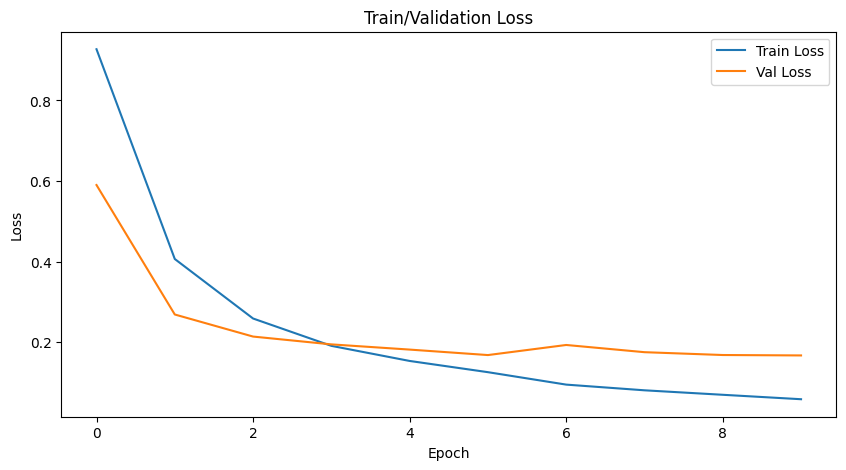

In [24]:
# Loss 시각화
######################
plt.figure(figsize=(10,5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title("Train/Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

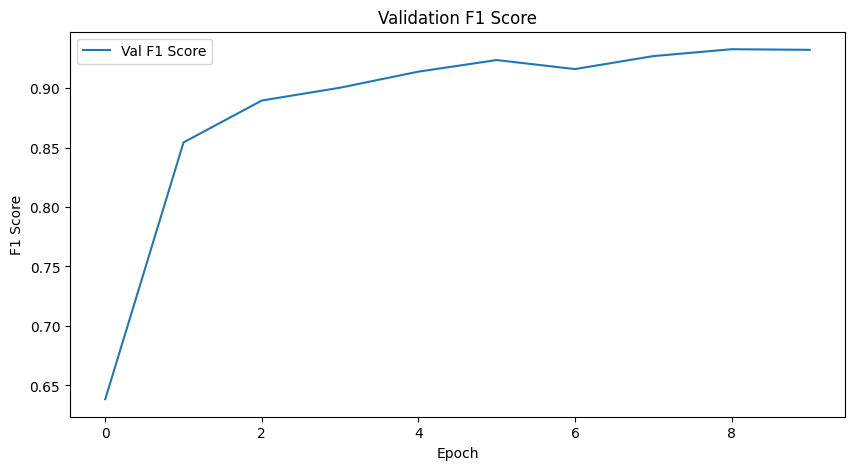

In [25]:
# F1 Score 시각화
plt.figure(figsize=(10,5))
plt.plot(val_f1_scores, label='Val F1 Score')
plt.title("Validation F1 Score")
plt.xlabel("Epoch")
plt.ylabel("F1 Score")
plt.legend()
plt.show()

In [26]:
# 테스트 데이터 예측
######################
model.eval()
predictions = []
with torch.no_grad():
    for batch in tqdm(test_loader, desc="Test Prediction"):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        predictions.extend(preds)

pred_labels = label_encoder.inverse_transform(predictions)
test_df["pred_class"] = pred_labels
test_df.to_csv("test_predictions_kcelectra.csv", index=False)


Test Prediction: 100%|██████████| 125/125 [00:17<00:00,  6.99it/s]


In [27]:
test_df['pred_class'].value_counts()

,count
pred_class,
기타 괴롭힘 대화,118
직장 내 괴롭힘 대화,111
갈취 대화,110
협박 대화,97
일반,64


In [28]:
sub = pd.read_csv('/content/sample_data/submission.csv')
sub['class'] = test_df['pred_class']

In [29]:
sub['idx'] = sub['file_name']
sub['target'] = sub['class']
sub = sub.drop(columns=['file_name','class'])
sub = sub[['idx', 'target']]
sub['target'] = sub['target'].apply(lambda x: 0 if x == '협박 대화' else
                                                   1 if x == '갈취 대화' else
                                                   2 if x == '직장 내 괴롭힘 대화' else
                                                   3 if x == '기타 괴롭힘 대화' else
                                                   4 if x == '일반' else None)


In [30]:
sub.to_csv('submission_kcelectra_augdata_1012.csv', index=False, encoding='utf-8-sig')